Here I present the work for FLAIR: Focused Learning AI Returner. This is AI/ML agent that takes in tracking data from the NFL of other players on the field and learns optimal return strategies! To accomplish this, I breakdown the process into three parts: Data Wrangling, Environment Development, and Agent Training. I also include mentions of its uses for a New Metric, Broadcast Potential, and Coaching.

# 1. Wrangle

The key here is to get the data we need, and in the usable format. This means that we have to extract just the "routine" kickoffs. These are the ones where the ball is kicked, caught, and returned, with no other events occluding this simple order (muffs, onsides, etc.) Naturally we will only be looking at kickoffs. Due to the tools, I used R to acheive this. 

First, I created a new ID field by concatenating the Game ID and Play ID (note the new ID is still unique). Then I ordered all of the data by Game and Frame, so the plays were tidy. I sent this CSV over to python for further editting.

Once I read in the data, I structured this database of plays by:
* Play
* * Frame
* * * (1) Returner
* * * (2-11) Returner's Teammates
* * * (12-22) Opponent Players

I only included frames from the point the kick was received and on, as this is the only data my agent needs to learn from.

# 2. Simulate!

So, now that I put my data in an easily accessible structure, it is time to set up the environment. This simplistic simulation allowed me to have the agent interact with the data. I let the agent control the direction it ran. (Later modifications allow us to control things like speed and acceleration, but to start I will just focus on direction, and use the returner's real speed). If it was too close to an opponent, without a teammate to block, then it was tackled and did not score as well, naturally. So, it was incentivised to avoid others and run forward. We also need to confine the AI to the field of play!

Similarly to the way the data was collected, I used frames, or steps, similar to OpenAI's gym, to create the environment, complete with __init__, reset(), step(), and render() functions. These allowed me to access the simulation and have the agent train. 

# 3. Train!

Once the environment was set up, I used a Deep Q Network to train the agent. There are extensive technical descriptions online; in short, I allowed the agent to explore, store up memories, and then learn from those memories to dread a Deep Neural Net. This would be allagous to having someone return a kickoff a million times, and as they are running, remember back to previous similar situations, and take an action that was useful before. (I let the agent see the whole field, which is not always accurate, but is a great future modification.)

The training results are here: We can see a bit of learning, so our agent is getitng better at returning, but this may take a lot of data. (I have more runs going now that I will post as soon as they are done!)

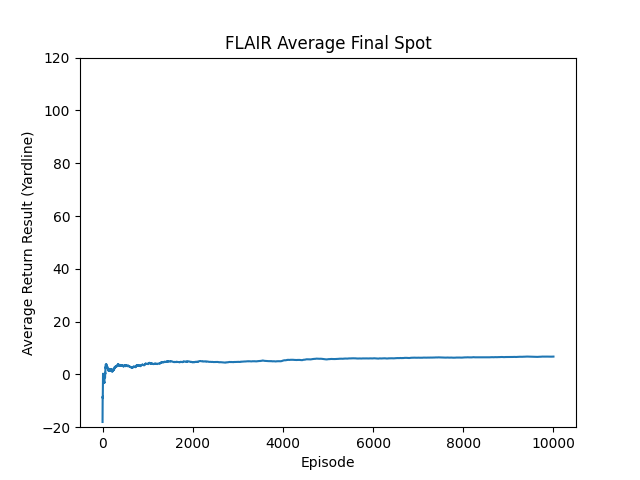

# 4. Impacts
Visualization: A development I am currently working on for FLAIR, is the visualization. Currently, it is not animated, but this is coming soon, and we will be able to watch the AI return. I wanted to include this, as it would be great to see the agent move around (I got stuck in the time crunch), but since we can see evidence of improvment of results, we know that there is some learning occurring.

Broadcast: It would great to be able to put a viz in the broadcast (similar to RomoVision) and have the audience follow along and compare the AI to real returners.

A New Statistic: If we say that FLAIR returns optimally, then we could compare a real returners return roucte, and decipher a Optimality Percentage of the player.

Coaching: While not fully accurate to in-game scenarios, FLAIR, with more enhancements, could be a useful coaching tool, as players and coaches could work out patterns and trends that FLAIR finds.



# 5. Discussion
It is always good to include some conceptual discussion!

I chose this model not only because of my familiarity with it, but also becuase the idea of practicing and storing memories translates nicely to the problem at hand. Having working with DQN's I was able to leverage some previous knowledge and tinker with the paramters a but to get them to work. Of course, this DQN can be trained more, and refined, which I am currently working on, what I show here is like a proof of concept.

I should note that for something like this, we have a small data set. (I only used 1877 plays, selecting a random one for the agent to train on.) In the scale of Reinforcement learning this can be vary small.

There is a natural extension to have this become a multi-agent model: the opponents just stop moving after the scripted data ends! Having an AI play for them, as well as the teammates is a geat extension.

I think what woudl be most effective is some reward shaping. Currently, I am just using the yardline of return to inform the agent, but I htink adding in things like broken tackles, avoiding and such would be usefull to.

In [ ]:
#The Following is the code base for verification, it is not all ironed out yet.
#Use with caution, and note the R and Python Code.

# #Big Data Bowl
# setwd("C:/Users/dcraw/OneDrive/Desktop/Data Analytics Bowl/nfl-big-data-bowl-2022")
# library(data.table)
# plays = fread("plays.csv")
# plays = cbind(id = paste0(plays$gameId, plays$playId), plays)
# 
# kickoff_plays = unique(plays$id[intersect(which(plays$specialTeamsPlayType == 'Kickoff'), which(plays$specialTeamsResult == "Return"))])
# 
# tracking_file_names = c("tracking2018.csv", "tracking2019.csv", "tracking2020.csv")
# tracking_data = data.table()
# 
# for(f in tracking_file_names){
#   tracking_data = rbind(tracking_data, fread(f))
# }
# 
# tracking_data = cbind(id = paste0(tracking_data$gameId, tracking_data$playId),tracking_data)
# 
# 
# kickoff_plays_tracking_data = tracking_data[which(tracking_data$id %in% kickoff_plays),]
# 
# 
# #Only kick received plays
# #get rid of punt
# get_rid_of = function(df, s){
#   plays = unique(df$id[which(df$event == s)])
#   return(df[!which(df$id %in% plays),])
# }
# 
# #carve
# df = get_rid_of(kickoff_plays_tracking_data, "punt")
# df = get_rid_of(df, "penalty_flag")
# df = get_rid_of(df, "fumble")
# df = get_rid_of(df, "handoff")
# df = get_rid_of(df, "onside_kick")
# df = get_rid_of(df, "drop_kick")
# df = get_rid_of(df, "onside_kick")
# df = get_rid_of(df, "out_of_bounds")
# df = get_rid_of(df, "fair_catch")
# df = get_rid_of(df, "kick_recovered")
# df = get_rid_of(df, "lateral")
# df = get_rid_of(df, "fumble_defense_recovered")
# df = get_rid_of(df, "fumble_offense_recovered")
# df = get_rid_of(df, "punt_downed")
# df = get_rid_of(df, "punt_received")
# df = get_rid_of(df, "autoevent_kickoff")
# df = get_rid_of(df, "free_kick")
# 
# df_ordered = df[with(df, order(df$id, df$frame, df$displayName)),]
# 
# fwrite(df_ordered, file = "simple_kickoff_plays_ordered.csv")

#STEP 1: Read In and Format Data
#Read in and manipulate the data
import torch
import csv
import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from itertools import groupby
import time
import torch.optim as optim
from collections import deque, namedtuple

def index_of_closest(f, x, y):
    cl_i = 0
    football_coords = np.array([float(x),float(y)])
    b = np.array([float(f[cl_i][2]), float(f[cl_i][3])])
    cl_d = np.linalg.norm(football_coords - b)
    for i in range(len(f)):
        player_coords = np.array([ float(f[i][2]) , float(f[i][3])])
        dist = np.linalg.norm(football_coords - player_coords)
        if dist < cl_d:
            cl_d = dist
            cl_i = i
    return cl_i              
        



file = open('C:/Users/dcraw/OneDrive/Desktop/Data Analytics Bowl/nfl-big-data-bowl-2022/simple_kickoff_plays_ordered.csv')

reader = csv.reader(file)
d = []
header = next(reader)
for r in reader:
    d.append(r)

a = [list(v) for l,v in groupby(sorted(d, key = lambda x:x[0]), lambda x: x[0])]

for p in a:
    for f in p:
            f[15] = int(f[15])


plays_db = []
for e in a:
    plays_db.append([list(v) for l,v in groupby(sorted(e, key = lambda x: x[15]), lambda x: x[15])])


#Flip plays to go one direction, to the right, meaning play direction is 'left'
for play in plays_db:
    if play[0][0][-1] == 'right':
        for frame in play:
            for d in frame:
                #print(d[11])
                if d[11] != 'football':
                    d[2] = float(d[2])-120.0
                    d[7] = 360.0 - float(d[7])
                    d[8] = 360.0 - float(d[8])
                    d[-1] = 'left'
    
#Id Returners
returners = {}
for play in plays_db:
    #index (frame) of 'kick_received'
    f = [x for x in play if x[0][9] == 'kick_received'][0]
    xf, yf = f[-1][2], f[-1][3]
    i = index_of_closest(f[0:22], xf, yf)
    #print(i)
    returners.update({play[0][i][0]: f[i][10]})


#Frame when ball caught
frame_when_received = {}
for play in plays_db:
    for frame in play:
        if frame[0][9] == "kick_received":
            frame_when_received.update({frame[0][0]: int(frame[0][15])})
            break


#Order: [0]: returner, [1:10]: teammates, [11:21]: opponents, [22]: ball
ordered_plays_db = []
for play in plays_db:
    ordered_play = []
    returner_id = returners[play[0][0][0]]
    for frame in play:
        ordered_frame = []
        if int(frame[0][15]) >= frame_when_received[frame[0][0]]:
            is_of_returner = [i for i,x in enumerate(frame) if x[10] == returner_id]
            i_r = is_of_returner[0]
            ordered_frame.append(frame[i_r])

            returner_team = frame[i_r][14]
            returner_teammates = [x for i,x in enumerate(frame) if x[14] == returner_team]
            returner_teammates.remove(frame[i_r])
            for tm in returner_teammates:
                ordered_frame.append(tm)

            opposition_players = [x for i,x in enumerate(frame) if x[14] != returner_team]
            for opp in opposition_players:
                ordered_frame.append(opp)
                    
            ordered_play.append(ordered_frame)

    ordered_plays_db.append(ordered_play)


#STEP 2: Initiate environment
#Set Up Environment
import numpy as np
import gym

def move(d,s,x,y):
    new_x = float(x) + float((np.sin(np.radians(d))*s))
    new_y = float(y) + float((np.cos(np.radians(d))*s))
    return new_x, new_y

def distance(a,b,c,d,m):
    return np.linalg.norm(np.array([a,b]) - np.array([c,c])) < m

def close(x1, y1, x2, y2, d):
    a = np.array([float(x1),float(y1)])
    b = np.array([float(x2),float(y2)])
    return np.linalg.norm(a-b) <= d

class KickoffReturn_ENV(gym.Env):
    
    def __init__(self):
        #self.action_space = gym.spaces.Box(
        #    low = 0.0,
        #    high = 359.99,
        #    shape = (1,1))

        #360 degrees
        self.action_space = gym.spaces.Discrete(360)
        
        #22 players: 1 self, 10 teammates, 11 opponents
        #each has (x, y, s, a, dis, o)
        self.observation_space = gym.spaces.Box(
            low = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
            high = np.array([120.0, 53.3, 100.0, 100.0, 10.0, 360.0]))
        

    def reset(self):
        self.state = np.array([[0.0]*6]*22)
        self.reward = 0
        self.done = False
        self.info = {}

        self.steps = 0

        return flatten_state(self.state)

    def step(self, action, players):

        players = players[:-1]
        
        if self.steps == 0:
            state_copy = []
            for p in players:
                #print(p)
                state_copy.append([float(d) for d in p[2:8]])
            
            self.state = state_copy
            
        spd = 0.8
        
        if self.done:
            print('Episode Over')
        else:
            assert self.action_space.contains(action)
            self.steps += 1


            if len(self.state) != 22:
                self.state = stack_state(self.state)
            #move agent
            agent_x = self.state[0][0]
            agent_y = self.state[0][1]

            #print(agent_x)
            self.state[0][0] = float(move(float(action), spd, agent_x, agent_y)[0])
            self.state[0][1] = float(move(float(action), spd, agent_x, agent_y)[1])

            #move others
            for i in range(21):
                self.state[i+1] = players[i+1][2:8]
            
            tackle_d = 1.0
            block_d = 0.5
            #check if tackle
            agent_state = self.state[0]
            for opp_state in self.state[11:21]:
                if close(agent_state[0],agent_state[1], opp_state[0], opp_state[1], tackle_d):
                #check if block
                    self.done = True
                    #self.reward = self.state[0][0]
                    for tm_state in self.state[1:10]:
                        if close(tm_state[0],tm_state[1], opp_state[0], opp_state[1], block_d):
                            self.done = False

            self.reward = self.state[0][0]

            state_copy = []
            for p in self.state:
                state_copy.append([float(d) for d in p])

            #Check In bounds
            if self.state[0][0] < 0.0 or self.state[0][0] > 100.0:
                self.done = True

            if self.state[0][1] < 0.0 or self.state[0][1] > 53.3:
                self.done = True
                
            self.state = flatten_state(state_copy)

            

            
            return self.state, self.reward, self.done, self.info

    def render(self):
        w = 100
        h = 53.3
        fig = plt.figure()
        
        ax = plt.axes(xlim = (-10, w + 30),
                      ylim = (-15, h + 5))
        
        plt.axis('off')

        #agent marker
        

        rect = matplotlib.patches.Rectangle(
            (-10, -5),
            w + 40,
            h + 10,
            linewidth = 1,
            facecolor = '#037f51',
            capstyle = 'round')
        ax.add_patch(rect)

        rect = plt.Rectangle(
            (0,0),
            w + 20,
            h,
            ec = 'w',
            fc = 'none',
            lw = 2)

        ax.add_patch(rect)

        ax.add_patch(plt.Circle((self.state[0][0], self.state[0][1]), 0.2, color='yellow'))

        for tm in self.state[1:11]:
            ax.add_patch(plt.Circle((float(tm[0]), float(tm[1])), 0.1, color='b'))

        for op in self.state[11:23]:
            ax.add_patch(plt.Circle((float(op[0]), float(op[1])), 0.1, color='r'))

        for i in range(21):
            plt.plot([10+5*i,10+5*i],
                     [0,h],
                     c = 'w',
                     lw = 2)
        
        
        fig.show()
        #fig, ax
        



def run_one_episode(env, play_data):
    env.reset()
    sum_r = 0

    for i in range(len(play_data)):
        action = env.action_space.sample()

        action = agent.get_action(env.state)

        players = play_data[i][0:22]
        
        s, r, d, i = env.step(action, players)

        #sum_r += r
        #env.render()
        if d:
            break

    return r

def flatten_state(s):
    return [float(x) for p in s for x in p]

def stack_state(s):
    a = []
    for i in range(22):
        b = []
        for j in range(6):
            b.append(float(s[i*0+j]))
        a.append(b)
            
    return a



class qnet(torch.nn.Module):
    def __init__(self, state_size, action_size, hidden_n):
        super(qnet, self).__init__()
        self.layer1 = torch.nn.Linear(state_size,hidden_n)
        self.layer2 = torch.nn.Linear(hidden_n,hidden_n)
        self.layer3 = torch.nn.Linear(hidden_n, action_size)

    def forward(self, x):
        x = self.layer1(x)
        x = torch.nn.functional.relu(x)
        x = self.layer2(x)
        x = torch.nn.functional.relu(x)
        x = self.layer3(x)
        return x


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    def __init__(self, state_size, action_size, learning_rate, batch_size, bank_size, hidden_n):
        self.state_size = state_size
        self.action_size = action_size

        self.net = qnet(state_size, action_size, hidden_n).to(device)
        self.target_net = qnet(state_size, action_size, hidden_n).to(device)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr = learning_rate)

        self.memories = ReplayBuffer(action_size, bank_size, batch_size)
        self.t = 0

    def step(self, state, action, r, next_state, terminated, tau, gamma, update_every, batch_size):
        self.memories.add(state, action, r, next_state, terminated)
        self.t += 1

        if self.t % update_every == 0:
            if len(self.memories) > batch_size:
                mems_to_learn_from = self.memories.sample()
                self.learn(mems_to_learn_from, gamma, tau)

    def act(self, state, epsilon = 0):
        state = torch.from_numpy(np.array(state)).float().unsqueeze(0).to(device)
        self.net.eval()
        with torch.no_grad():
            action_values = self.net(state)
        self.net.train()

        if np.random.random() > epsilon:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return np.random.choice(np.arange(self.action_size))

    def learn(self, memories, gamma, tau):
        states, actions, rs, next_states, terminateds = memories

        #next_qtargets = self.target_net(next_states).detech().max(1)[0].unsqueeze(1)
        next_qtargets = self.target_net(next_states).max(1)[0].unsqueeze(1)
        target_val = rs + gamma * next_qtargets*(1-terminateds)
        exp_val = self.net(states).gather(1,actions.type(torch.int64))

        loss = torch.nn.functional.mse_loss(exp_val, target_val)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.update(self.net, self.target_net, tau)

    def update(self, n, tn, tau):
        for target_param, param in zip(tn.parameters(), n.parameters()):
              target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)         

class ReplayBuffer:
    def __init__(self, action_size, bank_size, batch_size):
        self.batch_size = batch_size
        self.action_size = action_size
        self.memories = deque(maxlen=bank_size)
        self.memory = namedtuple("Memory", field_names=["state","action","reward","next_state","terminated"])


    def add(self, state, action, r, next_state, terminated):
        self.memories.append(self.memory(state, action, r, next_state, terminated))


    def sample(self):
        sampled_mems = random.sample(self.memories, self.batch_size)

        #print(torch.from_numpy(np.vstack([m.state for m in sampled_mems if m is not None])).float().to(device))

        states = torch.from_numpy(np.vstack([m.state for m in sampled_mems if m is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([m.action for m in sampled_mems if m is not None])).float().to(device)
        rs = torch.from_numpy(np.vstack([m.reward for m in sampled_mems if m is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([m.next_state for m in sampled_mems if m is not None])).float().to(device)
        terminateds = torch.from_numpy(np.vstack([m.terminated for m in sampled_mems if m is not None])).float().to(device)
        
        return (states, actions, rs, next_states, terminateds)

    def __len__(self):
        return len(self.memories)




def train_dqn(plays, num_eps, max_steps,
              epsilon, epsilon_min, epsilon_decay,
              tau, gamma, update_every, batch_size):

    terminal_rewards = []

    for ep_n in range(1, num_eps+1):

        #ENV
        env = KickoffReturn_ENV()
        
        play = random.choice(ordered_plays_db)
        state = env.reset()
        current_r = 0

        for step_n in range(max_steps):
            action_num = agent.act(state, epsilon)

            if step_n < len(play):
                players = play[step_n]
            else:
                players = play[-1]
                
            next_state, r, terminated, info = env.step(action_num, players)

        
            agent.step(state, action_num, r, next_state, terminated, tau, gamma, update_every, batch_size)
            state = next_state
            current_r = r
            if terminated:
                break
        terminal_rewards.append(current_r)
        epsilon = max(epsilon*epsilon_decay, epsilon_min)

        if ep_n % 1000 == 0:
            print("EPISODE:", ep_n, "   RETURNED TO:", current_r)

    return terminal_rewards

#PARAMS
NUMBER_OF_EPISODES = 100000
MAX_NUMBER_STEPS = 5000 
EPSILON = 1.0 
EPSILON_MIN = 0.01 
EPSILON_DECAY = 0.995 
TAU = 0.01 
GAMMA = 0.99 
LEARNING_RATE = 0.0005 
UPDATE_EVERY = 4 
BATCH_SIZE = 64 
BANK_SIZE = 100000
NUM_HIDDEN_NODES = 360



agent = Agent(132,360, LEARNING_RATE,
              BATCH_SIZE, BANK_SIZE,NUM_HIDDEN_NODES)

#def __init__(self, state_size, action_size,
#             learning_rate, batch_size, bank_size, hidden_n):
    
scores = train_dqn(ordered_plays_db, NUMBER_OF_EPISODES, MAX_NUMBER_STEPS,
                   EPSILON, EPSILON_MIN, EPSILON_DECAY, TAU,
                   GAMMA, UPDATE_EVERY, BATCH_SIZE)



plt.plot(range(len(scores)), scores)
plt.title("FLAIR Returning Final Spot")
plt.xlabel("Episode")
plt.ylabel("Return Result (Yardline)")
plt.ylim(-20,120)
plt.show()

avs = []
for i in range(len(scores)):
    avs.append(np.array(scores[0:i]).mean())

plt.plot(range(len(avs)), avs)
plt.title("FLAIR Average Final Spot")
plt.xlabel("Episode")
plt.ylabel("Average Return Result (Yardline)")
plt.ylim(-20,120)
plt.show()

avs100 = []
for j in range(len(scores)):
    if j > 100:
        avs100.append(np.array(scores[-100:-1]).mean())
    
plt.plot(range(len(avs100)), avs100)
plt.title("FLAIR Average Final Spot of Previous 100 Returns")
plt.xlabel("Episode")
plt.ylabel("Average Return Result (Yardline)")
plt.ylim(-20,120)
plt.show()
